In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

pd.set_option('mode.chained_assignment',  None) #because of Error Message

elec=pd.read_csv('https://drive.google.com/uc?export=download&id=1fq9qDqXLiUm0un_saxAUpPsSJa05F_bV', index_col=0)
county=pd.read_csv('https://drive.google.com/uc?export=download&id=1LciKFXkb3MmpXFEHDk1Db8YFsK0liF3a')

data=elec.merge(county,left_on='FIPS',right_on='fips',how='left')

In [2]:

# for use election data whole of Alaska not county level
data=elec[elec['county_name']!='Alaska'].merge(
    county,left_on='FIPS',right_on='fips',how='left')
data_ak=elec[elec['county_name']=='Alaska'].drop_duplicates(
    ['votes_dem_2016','votes_gop_2016'])

data_ak['FIPS']=2000

data_ak=data_ak.merge(county,left_on='FIPS',right_on='fips',how='left')
data=pd.concat((data,data_ak),axis=0).sort_values('fips')


data['target']=(data['votes_dem_2016']>data['votes_gop_2016'])*1



# Goal find difference charcteristics of group of friendly to Democracy Party or Republication Party

In [3]:
# for find key value combinde_fips is unique key of data
data.nunique()

combined_fips       3113
votes_dem_2016      2687
votes_gop_2016      2903
total_votes_2016    2963
per_dem_2016        3112
                    ... 
AFN120207           2778
BPS030214            755
LND110210           3073
POP060210           1617
target                 2
Length: 75, dtype: int64

In [4]:
#because some per_point_diff_2012 and 2016 have negative value so i want to know 
#if per demo - per gop or per gop - per demo
data[data['per_point_diff_2012']<0][['per_dem_2012']],data[data['per_point_diff_2016']<0][
    ['per_dem_2016']]
# result all have lower than 0.5. so per_point_diff = per_gop - per_dem

(      per_dem_2012
 0         0.265758
 1         0.215666
 3         0.262186
 4         0.123478
 6         0.460508
 ...            ...
 3106      0.176850
 3107      0.284955
 3109      0.192594
 3110      0.203017
 3111      0.126994
 
 [2426 rows x 1 columns],
       per_dem_2016
 0         0.239569
 1         0.195653
 2         0.466603
 3         0.214220
 4         0.084699
 ...            ...
 3106      0.149872
 3107      0.194046
 3109      0.149261
 3110      0.143203
 3111      0.088182
 
 [2625 rows x 1 columns])

In [5]:
data['INC910213']

0       24571
1       26766
2       16829
3       17427
4       20730
        ...  
3107    30517
3108    43444
3109    25513
3110    28308
3111    28764
Name: INC910213, Length: 3113, dtype: int64

In [6]:
# Core is group's characteristic about perference of Dem and Rep 

#because when i control Income data -> average data is not percent so i cannot undertand that difference of average
#so i change to percent value of income -> 소득 순위 

data['INC910213'] = (data['INC910213']/data['INC910213'].max())* 100
data['INC110213'] = (data['INC110213']/data['INC110213'].max())* 100

Pref_Dem2012 = data.loc[data['per_dem_2012']>data['per_gop_2012']]
Pref_Dem2016 = data.loc[data['per_dem_2016']>data['per_gop_2016']]

Pref_Rep2012 = data.loc[data['per_dem_2012']<data['per_gop_2012']]
Pref_Rep2016 = data.loc[data['per_dem_2016']<data['per_gop_2016']]

Pref_Rep2012['per_point_diff_2012'] = abs(Pref_Rep2012['per_point_diff_2012'])
Pref_Rep2016['per_point_diff_2016'] = abs(Pref_Rep2016['per_point_diff_2016'])

In [7]:
print('Number of County which is prefer to Democracy %d(in 2012) %d(in 2016) '%(len(Pref_Dem2012),len(Pref_Dem2016)))
print('\nNumber of County which is prefer to Republication %d(in 2012) %d(in 2016) '%(len(Pref_Rep2012),len(Pref_Rep2016)))
# i found not equal number data of 2012(686+2426 = 3112) and 2013(488+2625=3113)

Number of County which is prefer to Democracy 686(in 2012) 488(in 2016) 

Number of County which is prefer to Republication 2426(in 2012) 2625(in 2016) 


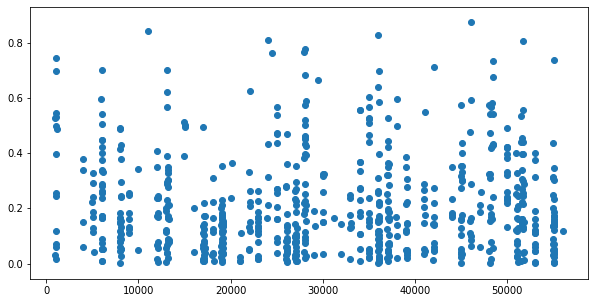

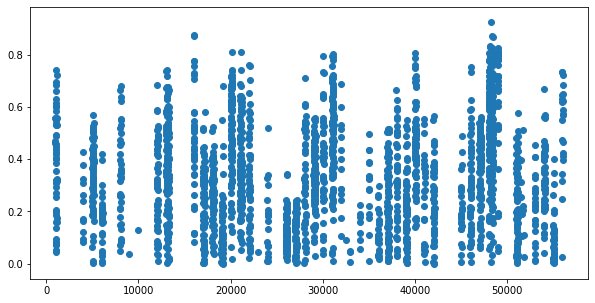

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(Pref_Dem2012['combined_fips'],Pref_Dem2012['per_point_diff_2012'])
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(Pref_Rep2012['combined_fips'],Pref_Rep2012['per_point_diff_2012'])

In [9]:
High_Pref_Dem2012 = Pref_Dem2012.loc[Pref_Dem2012['per_point_diff_2012']>
                                     Pref_Dem2012['per_point_diff_2012'].mean()]
High_Pref_Rep2012 = Pref_Rep2012.loc[Pref_Rep2012['per_point_diff_2012']>
                                    Pref_Rep2012['per_point_diff_2012'].mean()]
High_Pref_Dem2016 = Pref_Dem2016.loc[Pref_Dem2016['per_point_diff_2016']>
                                     Pref_Dem2016['per_point_diff_2016'].mean()]
High_Pref_Rep2016 = Pref_Rep2016.loc[Pref_Rep2016['per_point_diff_2016']>
                                    Pref_Rep2016['per_point_diff_2016'].mean()]

# 1. About  SEX & Race & Population Data

In [10]:
# 1st checking relationship between race & sex ~ prefercence Party
# RHI125214 - White alone, percent, 2014
# RHI225214 - Black or African American alone, percent, 2014
# RHI325214 - American Indian and Alaska Native alone, percent, 2014
# RHI425214 - Asian alone, percent, 2014
# RHI525214 - Native Hawaiian and Other Pacific Islander alone, percent, 2014
# RHI625214 - Two or More Races, percent, 2014
# RHI725214 - Hispanic or Latino, percent, 2014
# RHI825214 - White alone, not Hispanic or Latino, percent, 2014

# PST045214 - Population, 2014 estimate
# PST040210 - Population, 2010 (April 1) estimates base
# PST120214 - Population, percent change - April 1, 2010 to July 1, 2014
# POP010210 - Population, 2010
# POP645213 - Foreign born persons, percent, 2009-2013
# POP715213 - Living in same house 1 year & over, percent, 2009-2013

# in year 2014 data is used in 2016 election year's data PST045214
# in year 2010 data is used in 2012 election year's data PST040210,POP645213,POP715213

# SEX255214 - Female persons, percent, 2014

race = ['RHI225214', 'RHI325214', 'RHI425214','RHI525214', 'RHI625214', 'RHI725214', 'RHI825214']

corr_Dem2012 = High_Pref_Dem2012[race+['SEX255214','PST040210','POP645213','POP715213','per_point_diff_2012']].corr()[:11]
corr_Rep2012 = High_Pref_Rep2012[race+['SEX255214','PST040210','POP645213','POP715213','per_point_diff_2012']].corr()[:11]
corr_Dem2016 = High_Pref_Dem2016[race+['SEX255214','PST045214','POP645213','POP715213','per_point_diff_2016']].corr()[:11]
corr_Rep2016 = High_Pref_Rep2016[race+['SEX255214','PST045214','POP645213','POP715213','per_point_diff_2016']].corr()[:11]


diff_sex_race_average2012 = High_Pref_Dem2012[race+['SEX255214','PST040210','POP645213','POP715213']].mean() 
- High_Pref_Rep2012[race+['SEX255214','PST040210']].mean()

diff_sex_race_average2016 = High_Pref_Dem2016[race+['SEX255214','PST045214','POP645213','POP715213']].mean() 
- High_Pref_Rep2016[race+['SEX255214','PST045214']].mean()

corr_Dem2012.rename(columns = {'per_point_diff_2012':'dem_corr_per_point_diff_2012'},inplace=True)
corr_Rep2012.rename(columns = {'per_point_diff_2012':'rep_corr_per_point_diff_2012'},inplace=True)
corr_Dem2016.rename(columns = {'per_point_diff_2016':'dem_corr_per_point_diff_2016'},inplace=True)
corr_Rep2016.rename(columns = {'per_point_diff_2016':'rep_corr_per_point_diff_2016'},inplace=True)

result = pd.DataFrame([corr_Dem2012['dem_corr_per_point_diff_2012'],
                       corr_Rep2012['rep_corr_per_point_diff_2012'],
                       corr_Dem2016['dem_corr_per_point_diff_2016'],
                       corr_Rep2016['rep_corr_per_point_diff_2016'],
                       diff_sex_race_average2012,
                       diff_sex_race_average2016])
result = result.fillna(0)
result['PST040210'] = result['PST040210']+result['PST045214']
result.drop(columns = ['PST045214'],inplace = True)
result = result.transpose()

result.rename(index = {'PST040210':'Population'},columns = {'Unnamed 0': 'diff_average2012','Unnamed 1':'diff_average2016'},inplace=True)    

print('Race&Sex&Population result in 2016 vote election')
result
A = result.loc

Race&Sex&Population result in 2016 vote election


,dem_corr_per_point_diff_2012,rep_corr_per_point_diff_2012,dem_corr_per_point_diff_2016,rep_corr_per_point_diff_2016,diff_average2012,diff_average2016
RHI225214,0.182355,-0.225903,0.136992,-0.209210,26.475093,27.438119
RHI325214,0.155258,-0.081659,0.025468,-0.042861,4.489591,4.474257
RHI425214,0.135091,-0.124238,0.126916,-0.182547,3.761338,4.923762
RHI525214,0.090462,0.024889,-0.051708,-0.048821,0.266543,0.348515
RHI625214,0.046876,-0.134582,-0.054628,-0.088305,2.413011,2.621782
RHI725214,0.206932,0.145934,0.084923,0.083763,16.071375,19.103465
RHI825214,-0.485999,0.013026,-0.269674,0.051523,48.473606,43.254950
SEX255214,0.175440,-0.100083,0.138210,-0.064374,50.652045,51.002970
Population,0.092761,-0.173246,0.124200,-0.279434,319767.583643,431029.148515
POP645213,0.171305,0.138767,0.211444,0.062088,9.482156,11.851980


In [11]:
#RHI125214, RHI225214, RHI825214 have meaningful difference over 20% RHI725214 have also meaningful in 2012 2016
#meaning of the RHI125214 is include both RHI725214 and RHI825214 so i don't use RHI125214

selected_race = ['RHI825214']
selected_sex = ['SEX255214']

# 2. About Age Data

In [12]:
# AGE135214 - Persons under 5 years, percent, 2014
# AGE295214 - Persons under 18 years, percent, 2014
# R775214 - Persons 65 years and over, percent, 2014
# because age data in year2016 -> So used only 2016 vote result
# for calculating correlation and difference of average 
# i make new column percent of age between 18 to 64

age = ['AGE135214','AGE295214','AGE775214']

High_Pref_Dem2016['AGE18_64'] = 100 - (High_Pref_Dem2016[age[0]]+High_Pref_Dem2016[age[1]]+High_Pref_Dem2016[age[2]])
High_Pref_Rep2016['AGE18_64'] = 100 - (High_Pref_Rep2016[age[0]]+High_Pref_Rep2016[age[1]]+High_Pref_Rep2016[age[2]])
age = age+['AGE18_64']
        
corr_Dem2016 = High_Pref_Dem2016[age+['SEX255214','per_point_diff_2016']].corr()[:4]
corr_Rep2016 = High_Pref_Rep2016[age+['SEX255214','per_point_diff_2016']].corr()[:4]

corr_Dem2016.rename(columns = {'per_point_diff_2016':'dem_corr_per_point_diff_2016'},inplace=True)
corr_Rep2016.rename(columns = {'per_point_diff_2016':'rep_corr_per_point_diff_2016'},inplace=True)



diff_age_average2016 = High_Pref_Dem2016[age].mean() - High_Pref_Rep2016[age].mean()

result = pd.DataFrame([corr_Dem2016['dem_corr_per_point_diff_2016'],corr_Rep2016['rep_corr_per_point_diff_2016'],diff_age_average2016])
result = result.transpose()
result.rename(columns = {'Unnamed 0': 'diff_average2016'},inplace=True)

print('Age result in 2016 vote election')
result

Age result in 2016 vote election


,dem_corr_per_point_diff_2016,rep_corr_per_point_diff_2016,diff_average2016
AGE135214,0.131556,0.040791,0.592094
AGE295214,-0.022188,0.052504,0.103379
AGE775214,-0.184082,0.143362,-4.476632
AGE18_64,0.099188,-0.225647,3.781159


In [13]:
selected_age = ['AGE775214']

# 3.About Education Data and columns which can be applied only 2012 election data

In [14]:
# POP060210 - 인구밀집도
# LND110210 - Land area in square miles, 2010
# POP815213 - Language other than English spoken at home, pct age 5+, 2009-2013
# EDU635213 - High school graduate or higher, percent of persons age 25+, 2009-2013
# EDU685213 -Bachelor's degree or higher, percent of persons age 25+, 2009-2013
# Above 3 data can usesd in 2012 only because interval is 2009 to 2013


edu_others = ['POP060210','LND110210','POP815213','EDU635213','EDU685213']
corr_Dem2012 = High_Pref_Dem2012[edu_others+['per_point_diff_2012']].corr()[:len(edu_others)]
corr_Rep2012 = High_Pref_Rep2012[edu_others+['per_point_diff_2012']].corr()[:len(edu_others)]

corr_Dem2012.rename(columns = {'per_point_diff_2012':'dem_corr_per_point_diff_2012'},inplace=True)
corr_Rep2012.rename(columns = {'per_point_diff_2012':'rep_corr_per_point_diff_2012'},inplace=True)

diff_edu_others_average2012 = High_Pref_Dem2012[edu_others].mean() - High_Pref_Rep2012[edu_others].mean()

result = pd.DataFrame([corr_Dem2012['dem_corr_per_point_diff_2012'],corr_Rep2012['rep_corr_per_point_diff_2012'],diff_edu_others_average2012])
result = result.transpose()
result.rename(columns = {'Unnamed 0': 'diff_average2012'},inplace=True)

print('Education&Others result in 2012 vote election')
result

Education&Others result in 2012 vote election


,dem_corr_per_point_diff_2012,rep_corr_per_point_diff_2012,diff_average2012
POP060210,0.316682,-0.173931,1509.470802
LND110210,-0.023904,0.103395,-113.840957
POP815213,0.246394,0.112605,10.652564
EDU635213,-0.222494,0.065575,-1.044108
EDU685213,0.001393,0.082959,8.498965


In [15]:
print(High_Pref_Dem2012['POP060210'].describe())
print("\n",High_Pref_Rep2012['POP060210'].describe())

count      269.000000
mean      1570.233829
std       5622.774393
min          0.600000
25%         25.100000
50%         88.900000
75%       1144.900000
max      69467.500000
Name: POP060210, dtype: float64

 count    1163.000000
mean       60.763027
std       116.886489
min         0.100000
25%         7.150000
50%        28.000000
75%        67.600000
max      2315.300000
Name: POP060210, dtype: float64


In [16]:
selected_pop= ['POP060210']

# 4.About Income and Employment

In [17]:
# VET605213 - Veterans, 2009-2013
# LFE305213 - Mean travel time to work (minutes), workers age 16+, 2009-2013
# INC910213 - Per capita money income in past 12 months (2013 dollars), 2009-2013
# INC110213 - Median household income, 2009-2013
# PVY020213 - Persons below poverty level, percent, 2009-2013
# BZA010213 - Private nonfarm establishments, 2013
# BZA110213 - Private nonfarm employment, 2013
# BZA115213 - Private nonfarm employment, percent change, 2012-2013
# NES010213 - Nonemployer establishments, 2013

#'VET60513','LFE305213','INC910213','INC110213','PVY020213','BZA110213','BZA115213','NES010213' are used
# 2013 data is useful in 2012 election data 

inc_empl= ['VET605213','LFE305213','BZA010213','BZA110213','NES010213','INC910213','INC110213','PVY020213']
#VET,BZA person number, so when comparing average -> hard to how much difference -> So i change to percent
High_Pref_Dem2012['VET605213'] = (High_Pref_Dem2012['VET605213']/High_Pref_Dem2012['POP010210'])*100
High_Pref_Rep2012['VET605213'] = (High_Pref_Rep2012['VET605213']/High_Pref_Rep2012['POP010210'])*100
High_Pref_Dem2016['VET605213'] = (High_Pref_Dem2016['VET605213']/High_Pref_Dem2016['POP010210'])*100
High_Pref_Rep2016['VET605213'] = (High_Pref_Rep2016['VET605213']/High_Pref_Rep2016['POP010210'])*100

High_Pref_Dem2012['BZA110213'] = (High_Pref_Dem2012['BZA110213']/High_Pref_Dem2012['POP010210'])*100
High_Pref_Rep2012['BZA110213'] = (High_Pref_Rep2012['BZA110213']/High_Pref_Rep2012['POP010210'])*100
High_Pref_Dem2016['BZA110213'] = (High_Pref_Dem2016['BZA110213']/High_Pref_Dem2016['POP010210'])*100
High_Pref_Rep2016['BZA110213'] = (High_Pref_Rep2016['BZA110213']/High_Pref_Rep2016['POP010210'])*100


corr_Dem2012 = High_Pref_Dem2012[inc_empl+['per_point_diff_2012']].corr()[:len(inc_empl)]
corr_Rep2012 = High_Pref_Rep2012[inc_empl+['per_point_diff_2012']].corr()[:len(inc_empl)]
corr_Dem2016 = High_Pref_Dem2016[inc_empl+['per_point_diff_2016']].corr()[:len(inc_empl)]
corr_Rep2016 = High_Pref_Rep2016[inc_empl+['per_point_diff_2016']].corr()[:len(inc_empl)]


corr_Dem2012.rename(columns = {'per_point_diff_2012':'dem_corr_per_point_diff_2012'},inplace=True)
corr_Rep2012.rename(columns = {'per_point_diff_2012':'rep_corr_per_point_diff_2012'},inplace=True)
corr_Dem2016.rename(columns = {'per_point_diff_2016':'dem_corr_per_point_diff_2016'},inplace=True)
corr_Rep2016.rename(columns = {'per_point_diff_2016':'rep_corr_per_point_diff_2016'},inplace=True)

diff_inc_empl_average2012 = High_Pref_Dem2012[inc_empl].mean() - High_Pref_Rep2012[inc_empl].mean()
diff_inc_empl_average2016 = High_Pref_Dem2016[inc_empl].mean() - High_Pref_Rep2016[inc_empl].mean()

result = pd.DataFrame([corr_Dem2012['dem_corr_per_point_diff_2012'],
                       corr_Rep2012['rep_corr_per_point_diff_2012'],
                       corr_Dem2016['dem_corr_per_point_diff_2016'],
                       corr_Rep2016['rep_corr_per_point_diff_2016'],
                       diff_inc_empl_average2012,
                       diff_inc_empl_average2016])
result = result.transpose()
result.rename(columns = {'Unnamed 0': 'diff_average2012','Unnamed 1': 'diff_average2016'},inplace=True)

print('Income&Employment result in 2012 vote election')
result


Income&Employment result in 2012 vote election


,dem_corr_per_point_diff_2012,rep_corr_per_point_diff_2012,dem_corr_per_point_diff_2016,rep_corr_per_point_diff_2016,diff_average2012,diff_average2016
VET605213,-0.333662,-0.181628,-0.327463,-0.136206,-1.707864,-2.316656
LFE305213,0.147855,-0.185062,0.246388,-0.143512,1.064067,0.976849
BZA010213,0.089225,-0.152350,0.137682,-0.270568,7581.250141,10341.104683
BZA110213,0.006862,-0.065322,0.082944,-0.139382,9.483454,13.725231
NES010213,0.091184,-0.126085,0.121689,-0.235772,24831.398041,34518.295129
INC910213,-0.068625,0.121061,0.123475,0.087211,2.878124,5.526776
INC110213,-0.130169,0.118910,0.032497,-0.000742,1.253961,4.034725
PVY020213,0.311761,-0.145193,0.132606,-0.052317,5.257481,5.264090


In [18]:
print(data[['NES010213','LFE305213','INC910213','INC110213']].describe())

print("\n",data[['NES010213','LFE305213','INC910213','INC110213']].describe())
#--> for understanding of difference of average -> i change income and Population data to percentage value
# income percent -> show difference in income-level

           NES010213    LFE305213    INC910213    INC110213
count    3113.000000  3113.000000  3113.000000  3113.000000
mean     7390.043367    23.088789    37.709656    37.458702
std     28323.533632     5.358053     8.868059     9.660419
min         0.000000     8.200000    14.029249    16.350071
25%       746.000000    19.300000    31.839419    31.179339
50%      1656.000000    22.800000    36.625172    36.084524
75%      4259.000000    26.500000    41.902141    41.644170
max    945941.000000    44.200000   100.000000   100.000000

            NES010213    LFE305213    INC910213    INC110213
count    3113.000000  3113.000000  3113.000000  3113.000000
mean     7390.043367    23.088789    37.709656    37.458702
std     28323.533632     5.358053     8.868059     9.660419
min         0.000000     8.200000    14.029249    16.350071
25%       746.000000    19.300000    31.839419    31.179339
50%      1656.000000    22.800000    36.625172    36.084524
75%      4259.000000    26.500000    4

In [19]:
selected_inc = ['PVY020213']
selected_empl =['NES010213']

In [20]:
#이후 시나리오 선택된 column들 중에서 3개 선택 조합 만들어 -> 그다음 모델링을해 -> Model validation 통해서 high accuracy 선택 
#그 선택된 변수 데이터로 예측값 구한 후 accuracy ,recall, precision ,F1 구해서 결과 도출 
variable_list = selected_age+selected_race + selected_sex+ selected_pop+selected_inc+selected_empl

In [21]:
variable_list

['AGE775214', 'RHI825214', 'SEX255214', 'POP060210', 'PVY020213', 'NES010213']

In [22]:
variable_set = list(itertools.combinations(variable_list,3))

for i in range(len(variable_set)):
    variable_set[i] = list(variable_set[i])
    

In [23]:
data.reset_index(drop=True,inplace=True)

logi = LogisticRegression(C=1)
kfold = KFold(n_splits=5,shuffle=True)

score_list = []
val_score_list = [] 
target = data['target']

report_set = []
#these 3 list are used after filter variable sets for representing classfication report and roc curve
y_true = []
y_pred = [] 
y_proba = []
for i in variable_set:
    train_X,test_X,train_y,test_y = train_test_split(data[i], target, test_size=0.2, stratify=target, random_state=10)
    logi.fit(train_X,train_y)
    score_list.append(logi.score(test_X,test_y))
    each_val_score = []
    y_true.append(test_y)
    y_pred.append(logi.predict(test_X))
    y_proba.append(logi.predict_proba(test_X))
    
    for train_idx, test_idx in kfold.split(data):
        train_X, val_X = data[i].iloc[train_idx],data[i].iloc[test_idx]
        train_y, val_y = target[train_idx],target[test_idx]
        logi.fit(train_X,train_y)
        each_val_score.append(logi.score(val_X,val_y))
    
    

    val_score_list.append(each_val_score) 
    


In [24]:
mean_val_score = []
for i in range(len(val_score_list)):
    mean_val_score.append(np.mean(val_score_list[i]))
print("max %.4f" %(max(mean_val_score)))
mean_val_score

max 0.9065


[0.8859702817504761,
 0.9029940181571382,
 0.8769701630426369,
 0.8846830758749542,
 0.8743962674126337,
 0.8602607443497648,
 0.8721490764013977,
 0.8824219495956191,
 0.8782558205550366,
 0.8811419694146672,
 0.9065186087441226,
 0.888210763188183,
 0.8991391101041017,
 0.9045950256254096,
 0.884357919619309,
 0.8962410904605347,
 0.8785783962054781,
 0.8785701382688268,
 0.8708670317362828,
 0.8737588579273611]

In [25]:
top_index = []
mean_val_score
for i in range(len(variable_set)): 
    A = mean_val_score[i]
    if A>0.89:
        top_index.append(mean_val_score.index(A))
top_index        

[1, 10, 12, 13, 15]

In [26]:
new_variable_set = []
for i in top_index:
    new_variable_set.append(variable_set[i])
new_variable_set

[['AGE775214', 'RHI825214', 'POP060210'],
 ['RHI825214', 'SEX255214', 'POP060210'],
 ['RHI825214', 'SEX255214', 'NES010213'],
 ['RHI825214', 'POP060210', 'PVY020213'],
 ['RHI825214', 'PVY020213', 'NES010213']]

In [27]:
var_index = 0
for i in top_index:
    print(new_variable_set[var_index],"mean_score : " ,mean_val_score[i],"\n",
          classification_report(y_true[i],y_pred[i]))
    var_index = var_index + 1


['AGE775214', 'RHI825214', 'POP060210'] mean_score :  0.9029940181571382 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       525
           1       0.81      0.45      0.58        98

    accuracy                           0.90       623
   macro avg       0.86      0.71      0.76       623
weighted avg       0.89      0.90      0.88       623

['RHI825214', 'SEX255214', 'POP060210'] mean_score :  0.9065186087441226 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       525
           1       0.82      0.50      0.62        98

    accuracy                           0.90       623
   macro avg       0.86      0.74      0.78       623
weighted avg       0.90      0.90      0.89       623

['RHI825214', 'SEX255214', 'NES010213'] mean_score :  0.8991391101041017 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       525
           1


 ['AGE775214', 'RHI825214', 'POP060210']


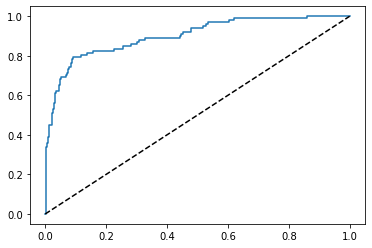


roc score is 0.8993

 ['RHI825214', 'SEX255214', 'POP060210']


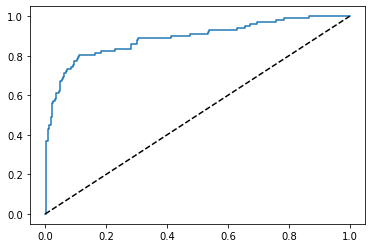


roc score is 0.8881

 ['RHI825214', 'SEX255214', 'NES010213']


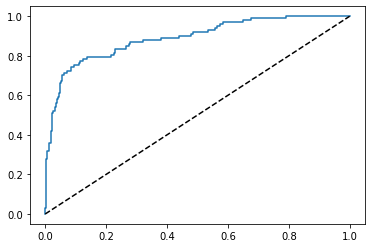


roc score is 0.8889

 ['RHI825214', 'POP060210', 'PVY020213']


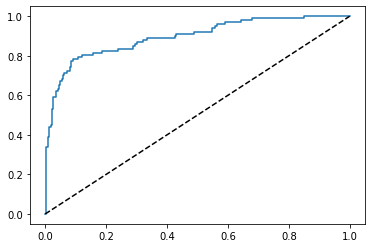


roc score is 0.8945

 ['RHI825214', 'PVY020213', 'NES010213']


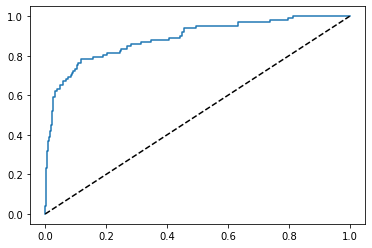


roc score is 0.8876


In [28]:
#for roc curve AUROC value
xx = np.linspace(0,1,10)
var_index = 0
for i in top_index:
    fpr, tpr, thresholds = roc_curve(y_true[i],y_proba[i][:,1],pos_label=1)
    print("\n",new_variable_set[var_index])
    plt.plot(fpr,tpr)
    plt.plot(xx,xx,'k--')#y = x graph
    plt.show()
    print("\nroc score is %.4f" %roc_auc_score(y_true[i],y_proba[i][:,1]))
    var_index = var_index+1